In [2]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
from parmesan.distributions import log_bernoulli, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
from parmesan.datasets import load_mnist_binarized
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [3]:
#settings
do_train_model = False
batch_size = 100
latent_size = 20
nhidden = 1024
lr = 0.0002
num_epochs = 100
model_filename = "mnist_vae"
nplots = 15
nonlin = lasagne.nonlinearities.rectify

np.random.seed(1234) # reproducibility

In [4]:
#SYMBOLIC VARS
sym_x = T.matrix()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using MNIST dataset"

train_x, valid_x, test_x = load_mnist_binarized()

train_x = np.concatenate([train_x, valid_x])

train_x = train_x.astype(theano.config.floatX)
test_x = test_x.astype(theano.config.floatX)

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

nfeatures=train_x.shape[1]
n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

Using MNIST dataset


In [5]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, nfeatures))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros(nfeatures, dtype = np.float32), name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.DenseLayer(l_noise, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE1')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE2')

l_mu = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_MU')
l_log_var = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_LOG_VAR')

#sample the latent variables using mu(x) and log(sigma^2(x))
l_z = SimpleSampleLayer(mean=l_mu, log_var=l_log_var)

In [6]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE2')
l_dec_h1 = lasagne.layers.DenseLayer(l_dec_h1, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE1')
l_dec_x_mu = lasagne.layers.DenseLayer(l_dec_h1, num_units=nfeatures, nonlinearity=lasagne.nonlinearities.sigmoid, name='DEC_X_MU')

# Get outputs from model
# with noise
z_train, z_mu_train, z_log_var_train, x_mu_train = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu], sym_x, deterministic=False
)

# without noise
z_eval, z_mu_eval, z_log_var_eval, x_mu_eval = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu], sym_x, deterministic=True
)

In [7]:
#Calculate the loglikelihood(x) = E_q[ log p(x|z) + log p(z) - log q(z|x)]
def ELBO(z, z_mu, z_log_var, x_mu, x):
    """
    Latent z       : gaussian with standard normal prior
    decoder output : bernoulli

    When the output is bernoulli then the output from the decoder
    should be sigmoid. The sizes of the inputs are
    z: (batch_size, num_latent)
    z_mu: (batch_size, num_latent)
    z_log_var: (batch_size, num_latent)
    x_mu: (batch_size, num_features)
    x: (batch_size, num_features)
    """
    kl_term = kl_normal2_stdnormal(z_mu, z_log_var).sum(axis=1)
    log_px_given_z = log_bernoulli(x, x_mu, eps=1e-6).sum(axis=1)
    LL = T.mean(-kl_term + log_px_given_z)

    return LL

# TRAINING LogLikelihood
LL_train = ELBO(z_train, z_mu_train, z_log_var_train, x_mu_train, sym_x)

# EVAL LogLikelihood
LL_eval = ELBO(z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, sym_x)

params = lasagne.layers.get_all_params(l_dec_x_mu, trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(-LL_train, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_DENSE1.W (784, 1024)
ENC_DENSE1.b (1024,)
ENC_DENSE2.W (1024, 1024)
ENC_DENSE2.b (1024,)
ENC_Z_MU.W (1024, 20)
ENC_Z_MU.b (20,)
ENC_Z_LOG_VAR.W (1024, 20)
ENC_Z_LOG_VAR.b (20,)
DEC_DENSE2.W (20, 1024)
DEC_DENSE2.b (1024,)
DEC_DENSE1.W (1024, 1024)
DEC_DENSE1.b (1024,)
DEC_X_MU.W (1024, 784)
DEC_X_MU.b (784,)


In [8]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], LL_train, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], LL_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], x_mu_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [9]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model([l_dec_x_mu], model_filename)
else:
    read_model([l_dec_x_mu], model_filename)
    

In [10]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")
    
def mnist_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 784)

def mnist_dist(img1, img2):
    return np.linalg.norm(img1 - img2)

In [11]:
def kld(mean1, log_var1, mean2, log_var2):
    mean_term = (T.exp(0.5*log_var1) + (mean1-mean2)**2.0)/T.exp(0.5*log_var2)
    return mean_term + log_var2 - log_var1 - 0.5

# Autoencoder outputs
mean, log_var, reconstruction = lasagne.layers.get_output(
    [l_mu, l_log_var, l_dec_x_mu], inputs = sym_x, deterministic=True)
    
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_mean =  T.vector()
adv_log_var = T.vector()
adv_confusion = kld(mean, log_var, adv_mean, adv_log_var).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_mean, adv_log_var, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_mean_log_var = theano.function([sym_x], [mean, log_var])

In [12]:
def adv_test(orig_img, target_img, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))
    
    # Get latent variables of the target
    adv_mean_values, adv_log_var_values = adv_mean_log_var(mnist_input(test_x[target_img]))
    adv_mean_values = adv_mean_values[0]
    adv_log_var_values = adv_log_var_values[0]

    original_reconstruction = adv_plot(mnist_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(mnist_input(test_x[target_img]))[0]

    orig_reconstruction_dist = mnist_dist(original_reconstruction, test_x[orig_img])
    target_reconstruction_dist = mnist_dist(target_reconstruction, test_x[target_img])
    
    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_mnist(test_x[orig_img], 1, "Original image")
        show_mnist(original_reconstruction, 2, "Original reconstruction")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g = adv_function(mnist_input(test_x[orig_img]), adv_mean_values, adv_log_var_values, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(mnist_input(test_x[orig_img]))[0]
    
    orig_dist = mnist_dist(adv_img, test_x[orig_img])
    adv_dist = mnist_dist(adv_img, test_x[target_img])
    
    # Plotting results
    if plot:
        show_mnist(x, 3, "Adversarial noise")
        show_mnist(test_x[target_img], 4, "Target image")
        show_mnist((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_mnist(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
            
    return orig_dist, adv_dist, orig_reconstruction_dist, target_reconstruction_dist

In [13]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_img = np.random.randint(0, len(test_x))
    
    print orig_img, target_img
    
    orig_dist=[]
    adv_dist=[]

    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ad, ore, tre = adv_test(orig_img, target_img, C=c, plot = False)
        orig_dist.append(od)
        adv_dist.append(ad)

    orig_dist = np.array(orig_dist)
    adv_dist = np.array(adv_dist)
    bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    _, _, orig_reconstruction_dist, target_reconstruction_dist = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        #plt.figure()
        #plt.plot(np.log(C), orig_dist, label = "Orig")
        #plt.plot(np.log(C), adv_dist, label = "Adv")
        #plt.ylabel("L2 norm")
        #plt.xlabel("Log regularization weight")
        #plt.legend()
        #plt.plot()

        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(adv_dist, orig_dist)
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    y = (orig_dist - target_reconstruction_dist)/orig_dist[0]
    x = (adv_dist - orig_reconstruction_dist)/adv_dist[-1]
    return x, y

8333 3156


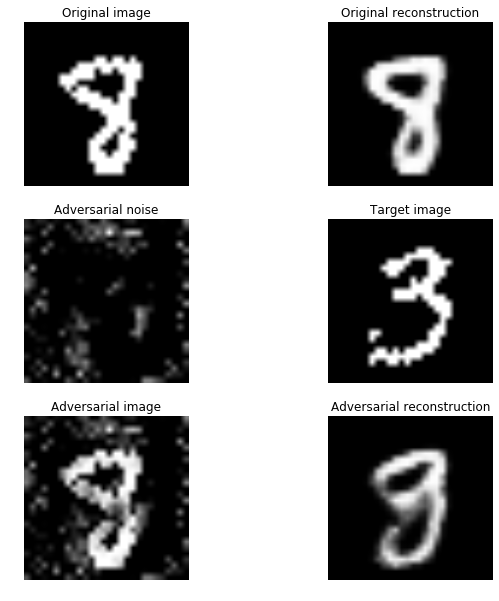

9368 794


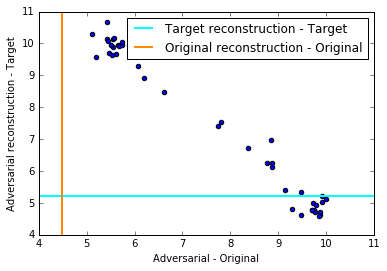

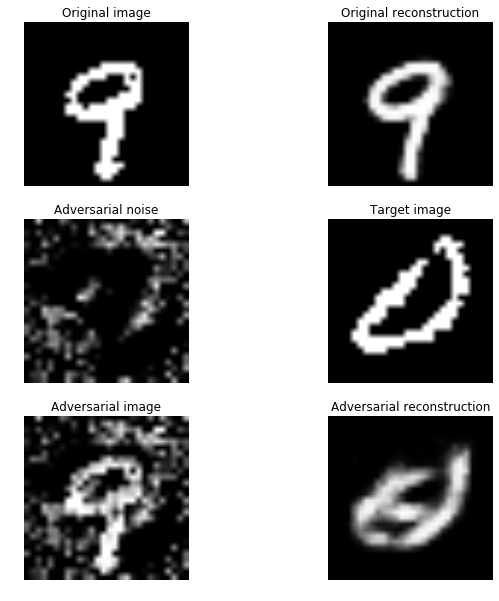

3396 4799


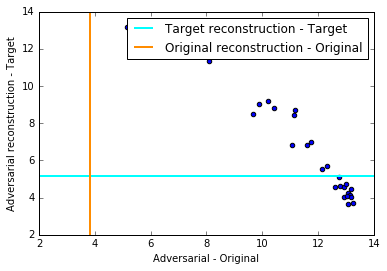

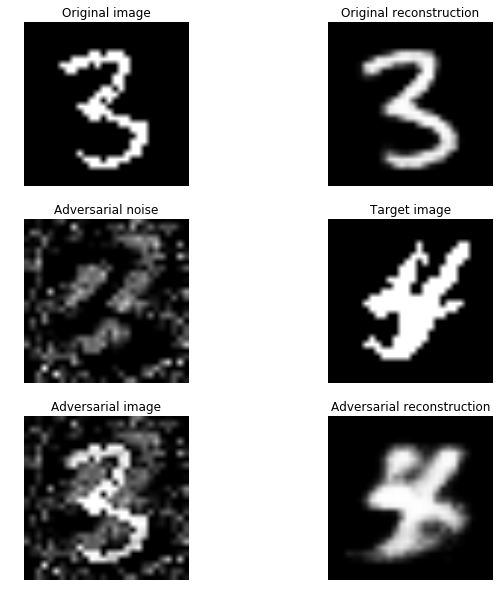

956 2507


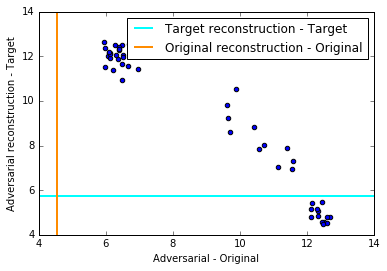

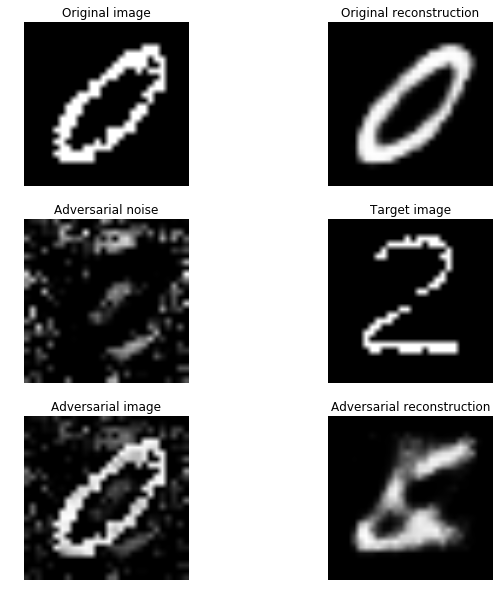

5236 1632


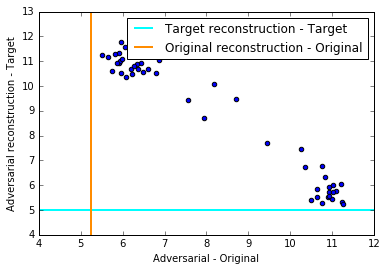

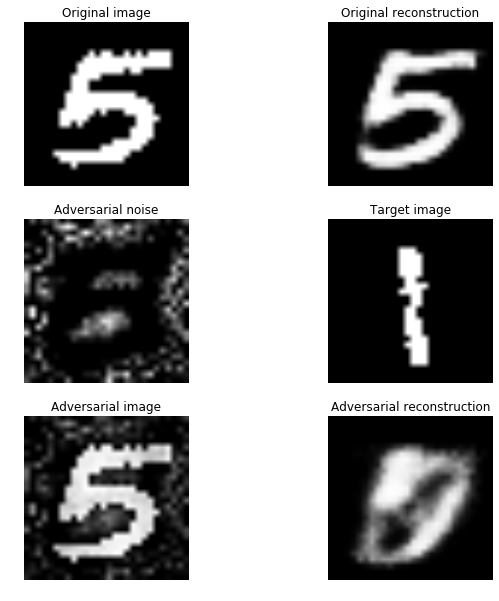

5197 7952


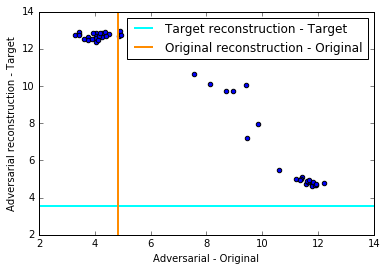

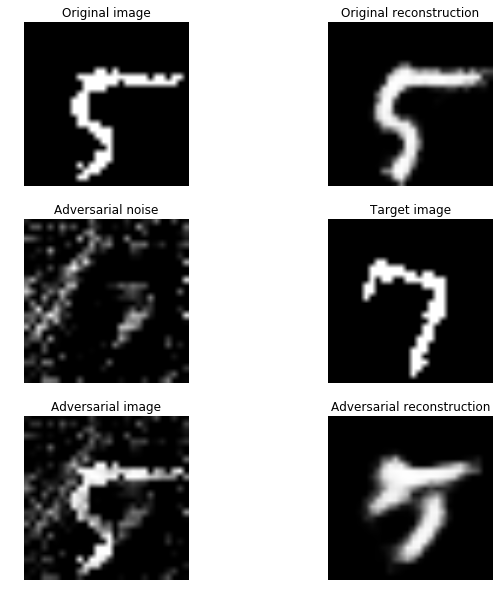

1834 75


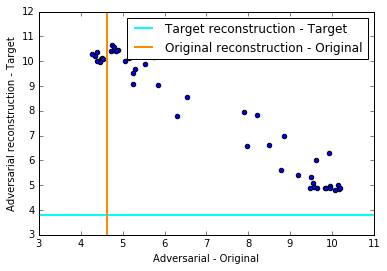

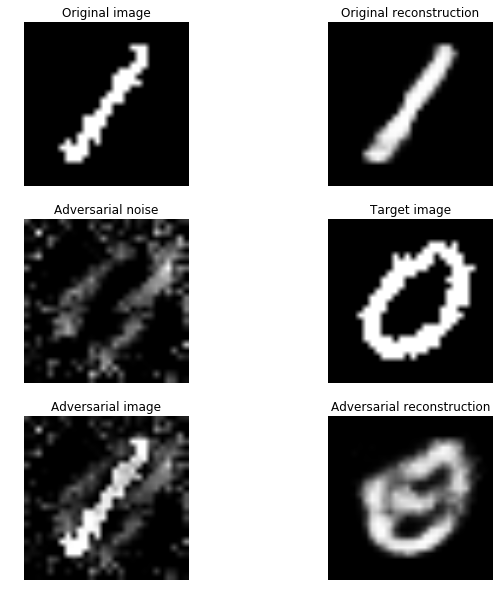

5811 1318


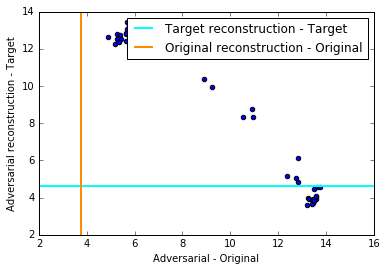

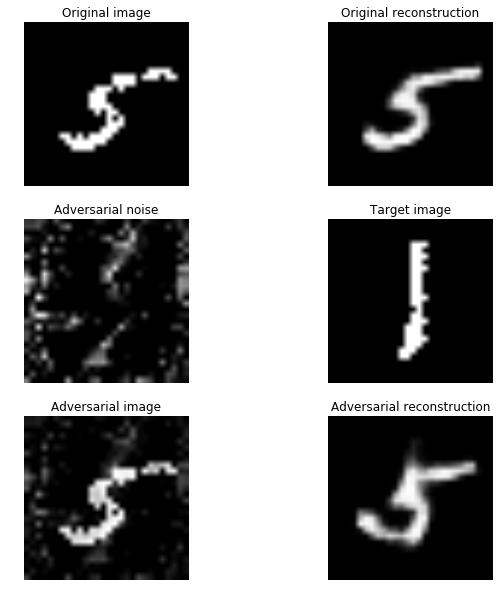

3243 5528


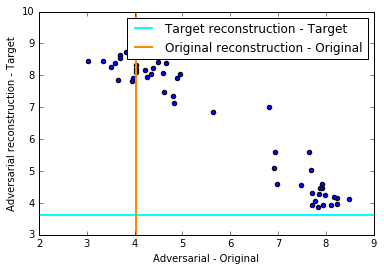

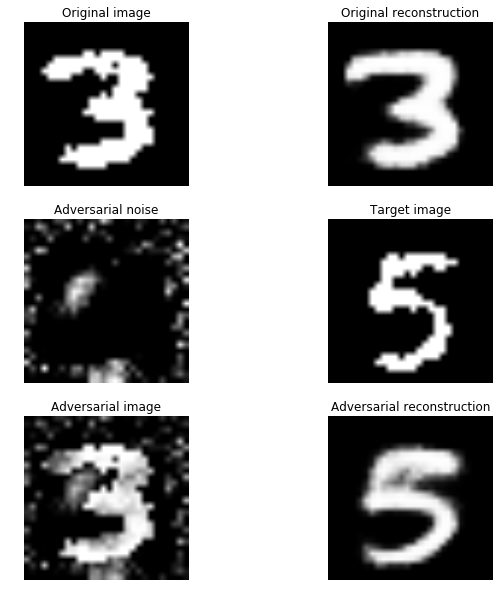

4789 2964


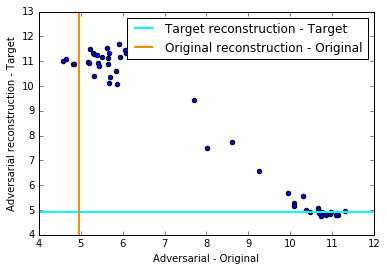

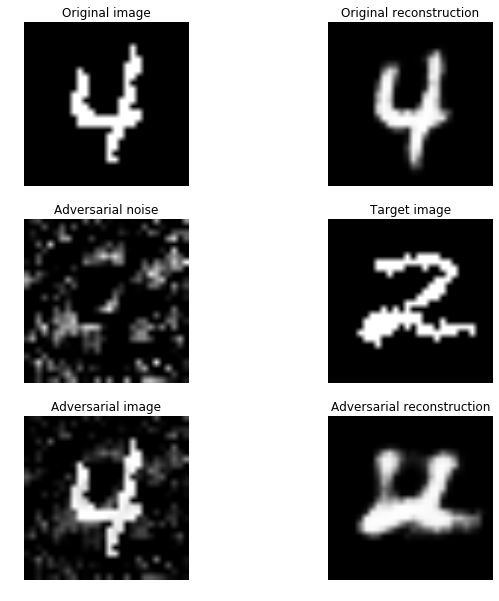

3758 4171


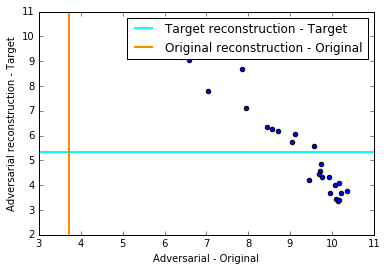

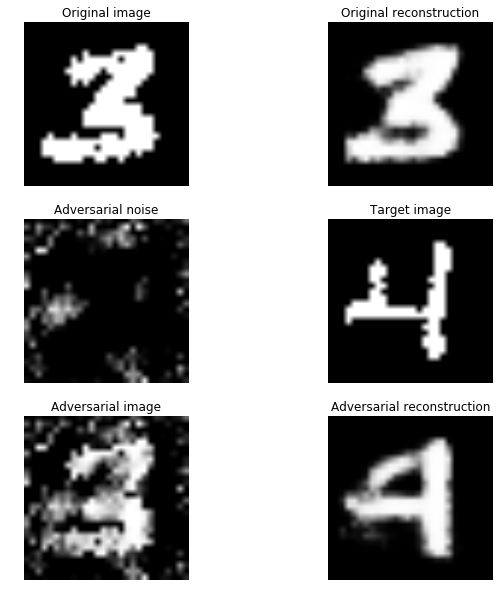

3440 276


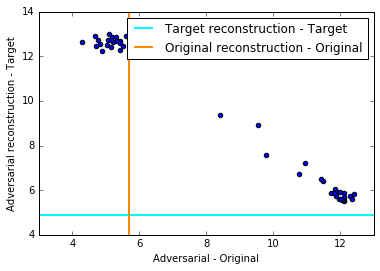

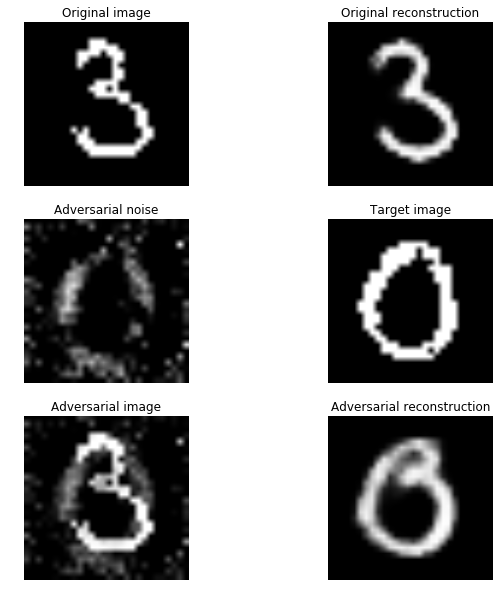

3316 3376


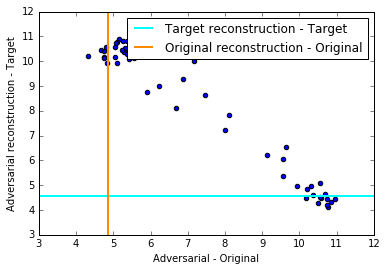

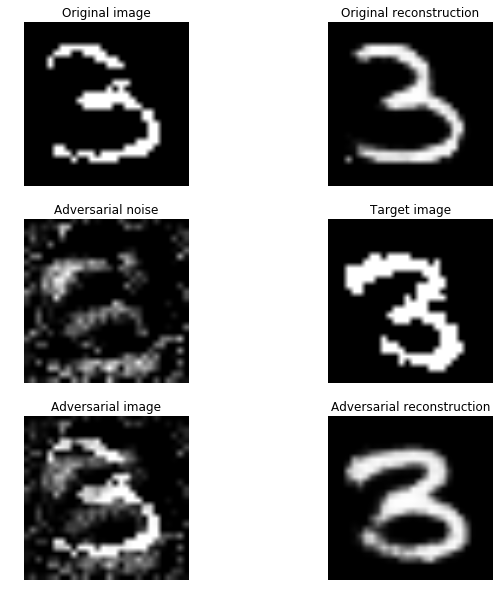

4083 6363


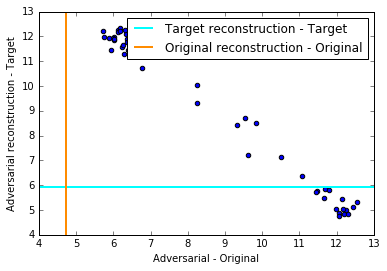

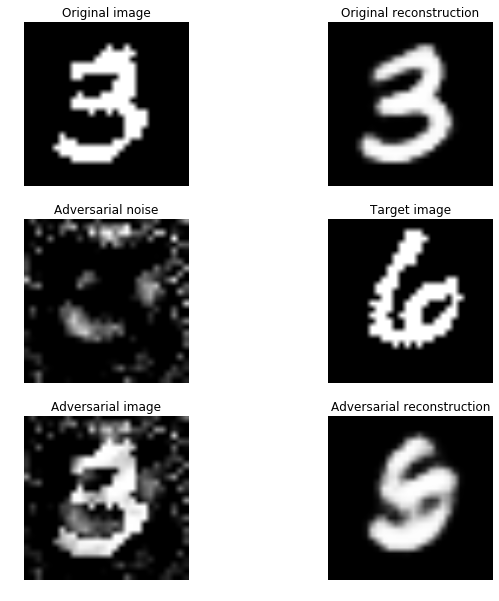

8935 1429


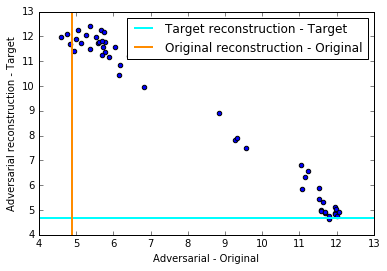

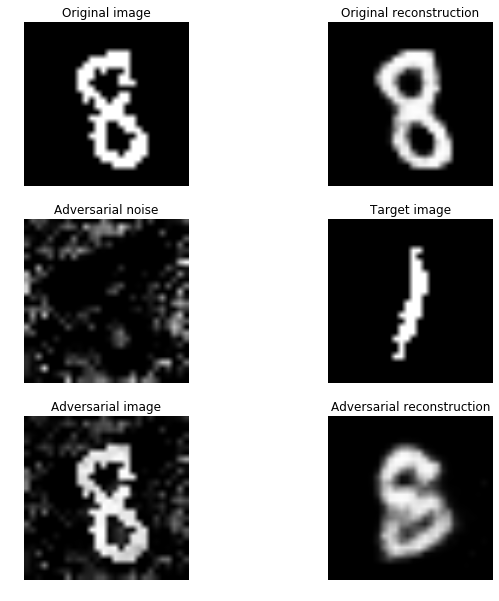

7821 5517


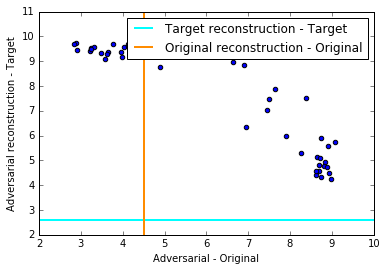

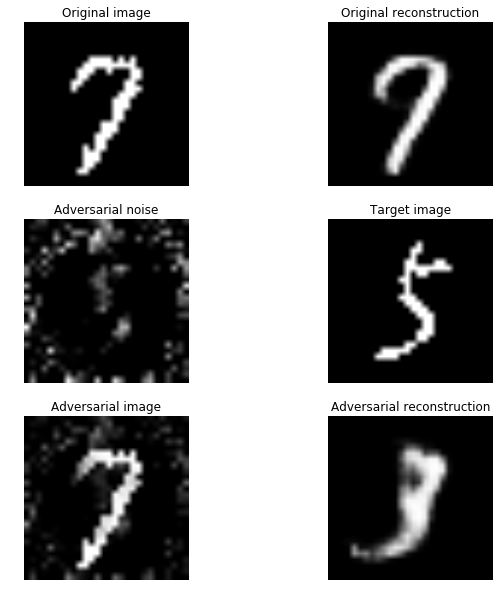

6458 7003


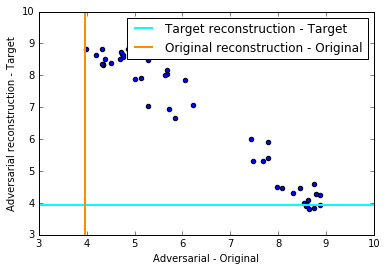

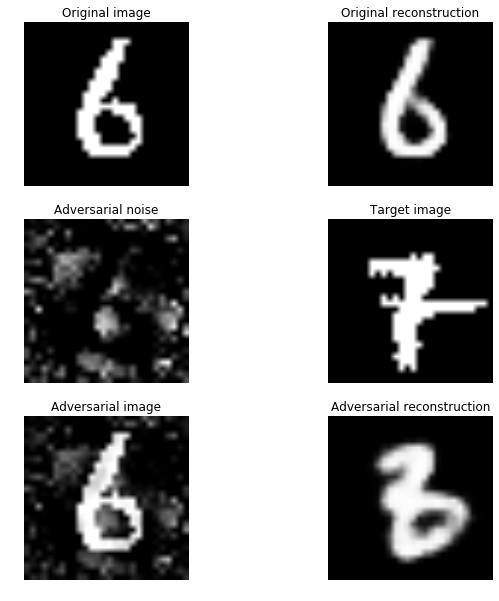

9165 66


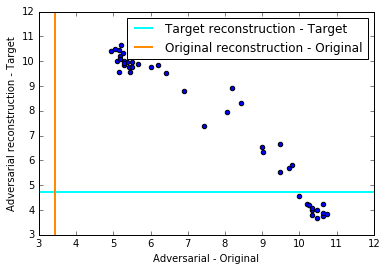

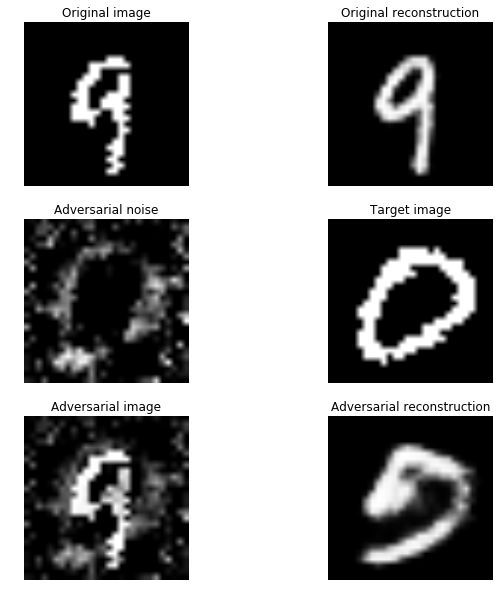

4239 3159


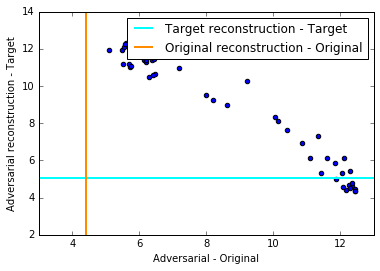

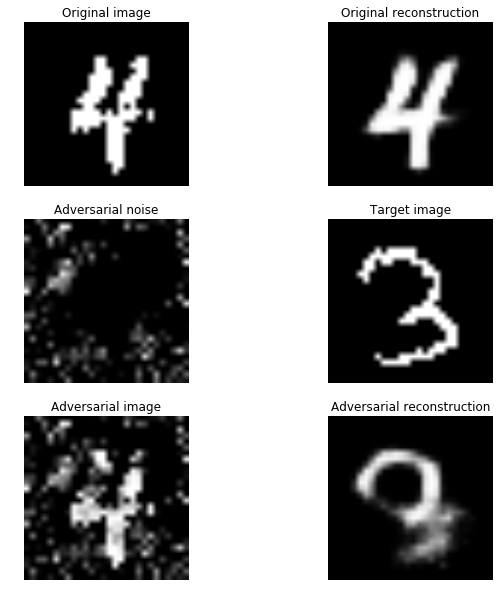

7879 5564


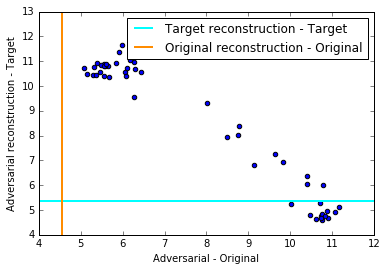

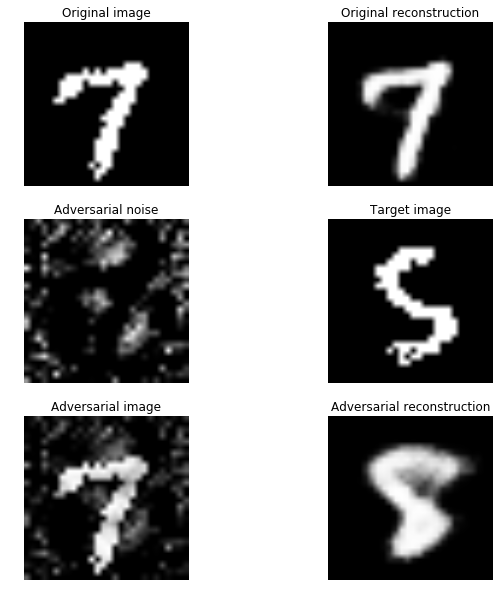

708 5056


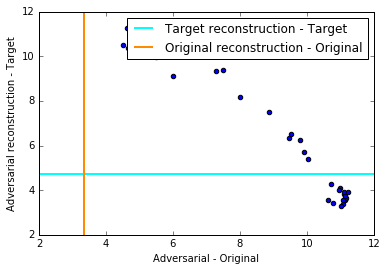

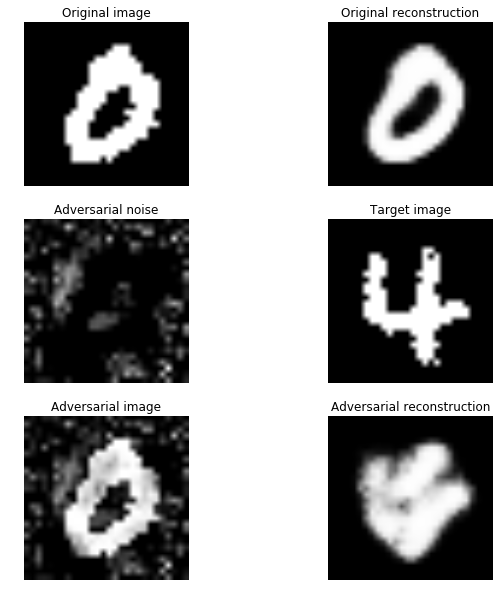

4423 3623


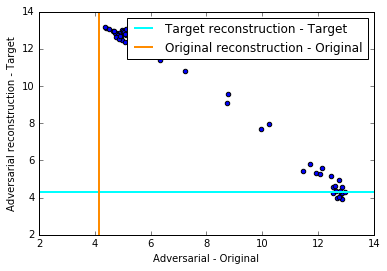

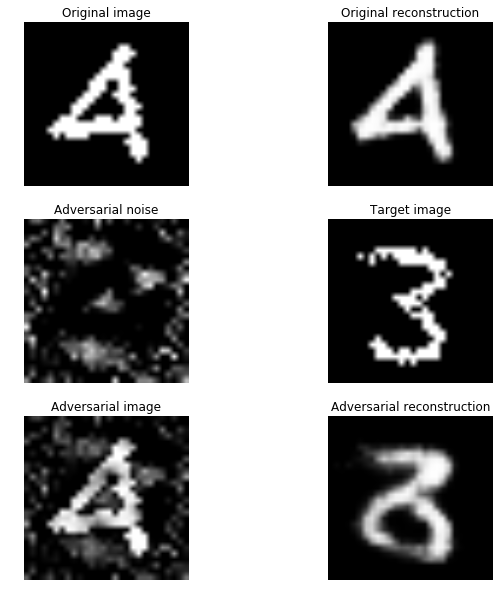

6831 3430


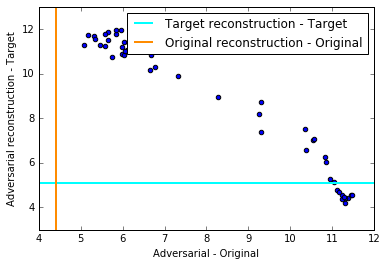

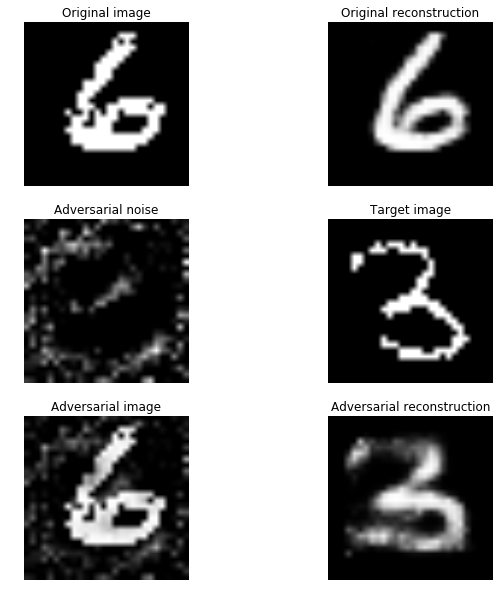

6060 7384


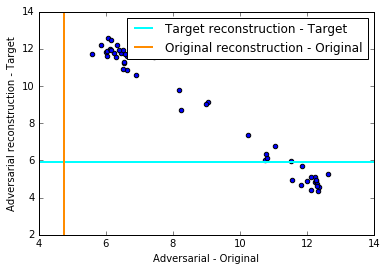

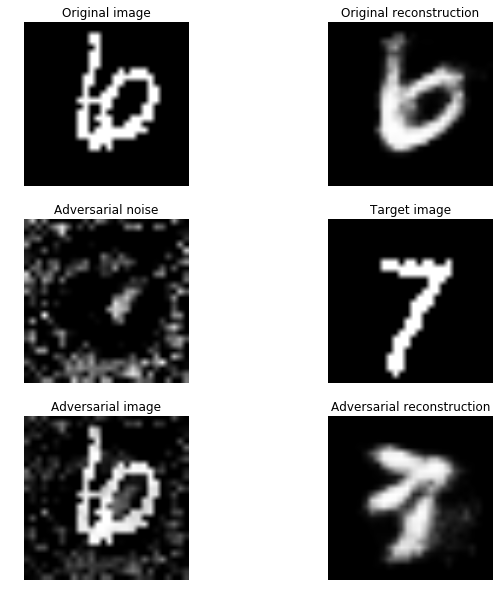

1971 4990


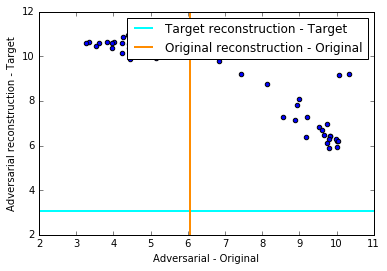

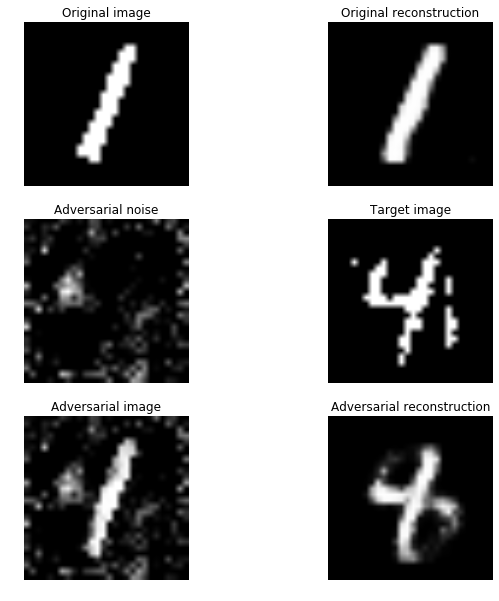

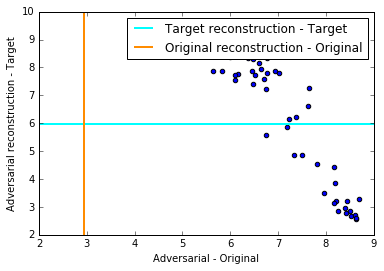

In [14]:
n = 25

xs = []
ys = []

for i in range(n):
    x, y = orig_adv_dist(plot = True)
    xs.append(x)
    ys.append(y)
    

<IPython.core.display.Javascript object>


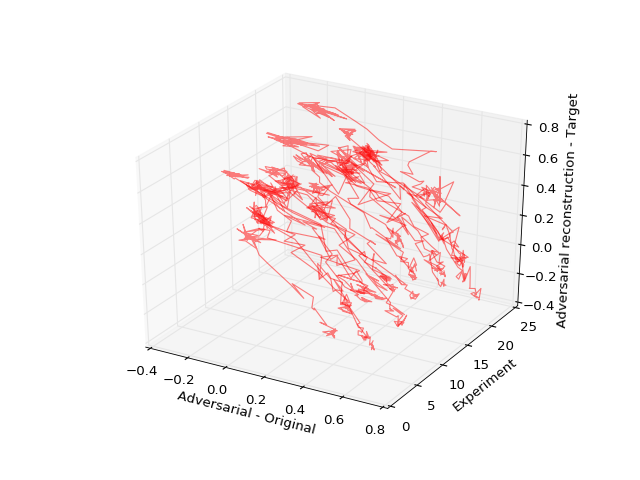

In [15]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    ax.plot(xs[i], [i]*len(xs[i]), ys[i], color = 'r', alpha = 0.5)

ax.set_xlabel('Adversarial - Original')
ax.set_ylabel('Experiment')
ax.set_zlabel('Adversarial reconstruction - Target')
plt.show()